In [25]:
import numpy as np

import scipy
from scipy.optimize import minimize
from scipy.stats import qmc
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error,root_mean_squared_error
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, MultiTaskElasticNetCV
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
training_cells = pd.read_csv("../Data_preprocessing/training.csv",header=None).to_numpy(dtype=str).reshape(-1,).tolist()
test_in_cells = pd.read_csv("../Data_preprocessing/test_in.csv",header=None).to_numpy(dtype=str).reshape(-1,).tolist()
test_out_cells = pd.read_csv("../Data_preprocessing/test_out.csv",header=None).to_numpy(dtype=str).reshape(-1,).tolist()
test_out_cells.remove('G40C3') # This cell has some issues on week 1 rpt, thus omitted

num_training_cells = len(training_cells)
num_test_in_cells = len(test_in_cells)
num_test_out_cells = len(test_out_cells)

a = np.loadtxt('../Empirical_model_fitting/Empirical_parameters_global_train_py.csv').item()

N_train = np.loadtxt("../Main_study/Processed_input_output/N_train.csv",delimiter=",")
N_test_in = np.loadtxt("../Main_study/Processed_input_output/N_test_in.csv",delimiter=",")
N_test_out = np.loadtxt("../Main_study/Processed_input_output/N_test_out.csv",delimiter=",")

Q_train = np.array([np.linspace(1,0.8,21)] * num_training_cells)
Q_test_in = np.array([np.linspace(1,0.8,21)] * num_test_in_cells)
Q_test_out = np.array([np.linspace(1,0.8,21)] * num_test_out_cells)


num_features = 11
param_bnd=(-10,10)

Define the empirical model

In [27]:
def empirical_model(global_p,b1,b2,b3,N_eq,b_weight=[1e-3,1e2,1e2]):
    a1 = global_p
    # Match the scaling for end-to-end formulation
    return 1 - b1*N_eq**a1*b_weight[0] - 1/(1+np.exp((b2*b_weight[1]-N_eq)/(b3*b_weight[2])))

Define end-to-end loss and constraints

In [28]:
# Two global power terms, four cell specific parameters.
def end_to_end_loss(W_,X,N,Q,a,alpha,rho): 
    # Without constraining the absolute values and add scaling for each X*wi
    n_features = X.shape[1]
    W = W_.reshape(n_features,3)
    len_interp = Q.shape[1]
    I_nm = np.ones_like(Q)
    I_1m = np.ones((1,len_interp))

    w1 = W[:,0].reshape(-1,1)
    w2 = W[:,1].reshape(-1,1)
    w3 = W[:,2].reshape(-1,1)

    # Terms inside the norm
    term_2 = X@w1@I_1m*1e-3 *  N**a
    term_3 = I_nm /( I_nm + np.exp(  (X@w2@I_1m*1e2 -N) / (X@w3@I_1m*1e2 ) ))

    loss_1 = np.mean(np.nanmean(np.array(I_nm - term_2 - term_3 - Q )**2,axis=1))
    loss_2 = np.sum(W[3:] ** 2) * 0.5 # L2 norm
    loss_3 = np.sum(np.abs(W[3:])) # L1 norm
    loss = loss_1 * 100 + alpha*(rho*loss_3 + (1-rho)*loss_2)
    return loss

# Define three nonlinear constraints to ensure b1, b2, b3 are all positive
def g1(W_,X_):
    n_features = X_.shape[1]
    W = W_.reshape(n_features,3)
    w1 = W[:,0].reshape(-1,1)    
    
    X = np.mat(X_)
    # Terms inside the norm
    b1 = X*w1
    return np.min(b1)

def g2(W_,X_):
    n_features = X_.shape[1]
    W = W_.reshape(n_features,3)
    X = np.mat(X_)
    w2 = W[:,1].reshape(-1,1)
    # Terms inside the norm
    b2 = X*w2
    return np.min(b2)

def g3(W_,X_):
    n_features = X_.shape[1]
    W = W_.reshape(n_features,3)
    X = np.mat(X_)
    w3 = W[:,2].reshape(-1,1)
    # Terms inside the norm
    b3 = X*w3
    return np.min(b3)

def visualize_opt_res(results):
    best_result = min(results, key=lambda x: x.fun)
    print(f"best MSE: {best_result.fun}")
    print(f"best W: {best_result.x}")

    obj_fun_values = [result.fun for result in results]
    s_or_f = np.array([result.success for result in results],dtype=int)
    fig,ax = plt.subplots(1,2,figsize=(6,2.5),dpi=100)
    ax[0].hist(obj_fun_values,bins=20, color='cornflowerblue', edgecolor='black')
    ax[0].set_xlabel('Objective function value')
    ax[0].set_ylabel('Frequency')

    ax[1].hist(s_or_f,color='cornflowerblue', edgecolor='black')
    ax[1].set_xlabel('Success/fail')
    ax[1].set_ylabel('Frequency')
    plt.tight_layout(pad=0.1)
    plt.show()
    return best_result

Define a train function

In [29]:
def train_e2e(feature,start_sample,method='SLSQP'):
    results = []
    cons = [
        {'type':'ineq','fun':g1,'args':(feature,)},
        {'type':'ineq','fun':g2,'args':(feature,)},
        {'type':'ineq','fun':g3,'args':(feature,)},
        ]

    for i in range(len(start_sample)):
        # print(f'Iteration: {i+1}')
        W0 = start_sample[i]
        alpha = 1e-6
        rho = 0.95
        # Minimization
        res = minimize(end_to_end_loss,W0,
                    args = (feature,N_train,Q_train,a,alpha,rho),
                    bounds = ((param_bnd, ) * len(W0)),
                    constraints = cons,
                    method = method,
                    options={'disp': False,'maxiter':500})
        results.append(res)

    best_result = visualize_opt_res(results)
    return results,best_result

In [30]:
# Multistart through Latin hypercube sampling
num_start = 100
sampler=qmc.LatinHypercube(d=num_features*3,seed=215)
sample = sampler.random(n=num_start)
lhs_lb = [param_bnd[0]+1e-2 for i in range(num_features*3)]
lhs_ub = [param_bnd[1]-1e-2 for i in range(num_features*3)]
sample_scaled = qmc.scale(sample,lhs_lb,lhs_ub)
method = 'SLSQP'

Week 1

/var/folders/v6/55gp8_yx1993x56b4qjh3zqr0000gn/T/ipykernel_4268/4075118342.py:16: RuntimeWarning: overflow encountered in exp
  term_3 = I_nm /( I_nm + np.exp(  (X@w2@I_1m*1e2 -N) / (X@w3@I_1m*1e2 ) ))
/Users/litingkai/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


best MSE: 0.03642441454715497
best W: [ 7.10873468 10.          2.17377019  0.17120354  0.90487737  0.31344192
 -0.15856228 -0.68239956 -0.18712505 -0.17662466 -0.44684936 -0.18998747
  0.21849223  0.88176519  0.13058953 -0.23086343  0.36456031  0.13158738
 -0.15269008  1.70543951  0.41858606  0.15744083  0.71936591  0.31824007
 -0.28729842 -0.18025017 -0.10628124 -0.24434959 -1.24618558 -0.1858844
  0.94295828  1.34149497  0.38204468]


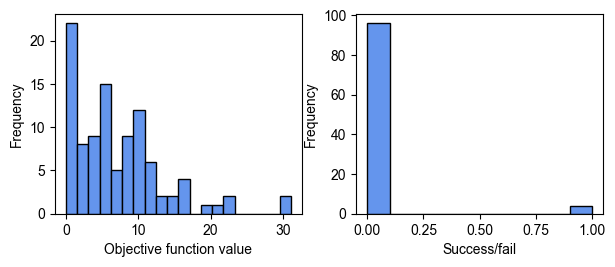

Mean RMSE Training: 1.776%
Mean RMSE High-DoD: 3.424%
Mean RMSE Low-DoD: 3.902%
Mean MAE Training: 1.485%
Mean MAE High-DoD: 2.885%
Mean MAE Low-DoD: 3.597%


In [31]:
X_train_PCA_1 = np.loadtxt("X_train_1_PCA.csv",delimiter=",")
X_test_in_PCA_1 = np.loadtxt("X_test_in_1_PCA.csv",delimiter=",")
X_test_out_PCA_1 = np.loadtxt("X_test_out_1_PCA.csv",delimiter=",")

X_train_PCA_1 = np.concatenate((np.ones((len(X_train_PCA_1),1)),X_train_PCA_1),axis=1)
X_test_in_PCA_1 = np.concatenate((np.ones((len(X_test_in_PCA_1),1)),X_test_in_PCA_1),axis=1)
X_test_out_PCA_1 = np.concatenate((np.ones((len(X_test_out_PCA_1),1)),X_test_out_PCA_1),axis=1)

results_1,best_result_1 = train_e2e(X_train_PCA_1,sample_scaled,method)

W_best_opt = best_result_1.x.reshape(num_features,3)
b_train_hat_e2e_1 = X_train_PCA_1@W_best_opt
b_test_in_hat_e2e_1 = X_test_in_PCA_1@W_best_opt
b_test_out_hat_e2e_1 = X_test_out_PCA_1@W_best_opt

# Evaluate training performance
Q_train_hat_e2e_1 = Q_train.copy()
RMSE_train_e2e_1 = []
MAE_train_ele_1 = []
for iii in range(len(Q_train)):
    Q_true = Q_train[iii]
    N_true = N_train[iii]
    Q_pred = empirical_model(a,*b_train_hat_e2e_1[iii],N_true)
    Q_train_hat_e2e_1[iii] = Q_pred

    RMSE_train_e2e_1.append(root_mean_squared_error(Q_true,Q_pred))
    MAE_train_ele_1.append(mean_absolute_error(Q_true,Q_pred))

# Evaluate test performance
Q_test_in_hat_e2e_1 = Q_test_in.copy()
RMSE_test_in_e2e_1 = []
MAE_test_in_e2e_1 = []
for iii in range(len(Q_test_in)):
    Q_true = Q_test_in[iii]
    N_true = N_test_in[iii]
    b_pred = np.abs(b_test_in_hat_e2e_1[iii])
    Q_pred = empirical_model(a,*b_pred,N_true)
    Q_test_in_hat_e2e_1[iii] = Q_pred

    RMSE_test_in_e2e_1.append(root_mean_squared_error(Q_true,Q_pred))
    MAE_test_in_e2e_1.append(mean_absolute_error(Q_true,Q_pred))

# Evaluate test performance
Q_test_out_hat_e2e_1 = Q_test_out.copy()
RMSE_test_out_e2e_1 = []
MAE_test_out_e2e_1 = []
for iii in range(len(Q_test_out)):
    Q_true = Q_test_out[iii]
    N_true = N_test_out[iii]
    b_pred = np.abs(b_test_out_hat_e2e_1[iii])
    Q_pred = empirical_model(a,*b_pred,N_true)
    Q_test_out_hat_e2e_1[iii] = Q_pred

    RMSE_test_out_e2e_1.append(root_mean_squared_error(Q_true,Q_pred))
    MAE_test_out_e2e_1.append(mean_absolute_error(Q_true,Q_pred))


print(f'Mean RMSE Training: {np.mean(RMSE_train_e2e_1)*100:.3f}%')
print(f'Mean RMSE High-DoD: {np.mean(RMSE_test_in_e2e_1)*100:.3f}%')
print(f'Mean RMSE Low-DoD: {np.mean(RMSE_test_out_e2e_1)*100:.3f}%')

print(f'Mean MAE Training: {np.mean(MAE_train_ele_1)*100:.3f}%')
print(f'Mean MAE High-DoD: {np.mean(MAE_test_in_e2e_1)*100:.3f}%')
print(f'Mean MAE Low-DoD: {np.mean(MAE_test_out_e2e_1)*100:.3f}%')

Week 2

/var/folders/v6/55gp8_yx1993x56b4qjh3zqr0000gn/T/ipykernel_4268/4075118342.py:16: RuntimeWarning: overflow encountered in exp
  term_3 = I_nm /( I_nm + np.exp(  (X@w2@I_1m*1e2 -N) / (X@w3@I_1m*1e2 ) ))
/Users/litingkai/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


best MSE: 0.035648869681073586
best W: [ 6.90265421e+00  1.00000000e+01  2.25400100e+00  2.16305472e-01
  8.84731654e-01  2.95160545e-01 -1.33862141e-01 -3.37642061e-01
 -8.70842203e-02  1.68171314e-01  8.03724063e-01  2.95408666e-01
 -7.23510270e-02  2.33513298e-01  5.74457902e-03 -2.44965620e-01
 -2.43680573e-01 -2.68993589e-02 -2.61239394e-01 -1.62420668e+00
 -3.62696757e-01 -5.54782721e-02  1.19393997e+00  3.01734841e-01
  3.90699331e-01 -6.77230274e-01 -1.87246923e-01 -6.79534134e-01
 -1.22542716e+00 -4.40610425e-01  1.49440451e-01  1.27961948e+00
  2.36023443e-01]


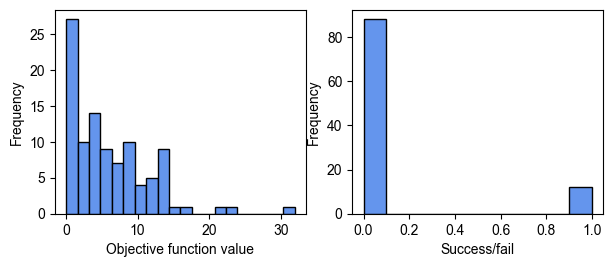

Mean RMSE Training: 1.777%
Mean RMSE High-DoD: 2.527%
Mean RMSE Low-DoD: 9.096%
Mean MAE Training: 1.499%
Mean MAE High-DoD: 2.088%
Mean MAE Low-DoD: 6.653%


In [32]:
X_train_PCA_2 = np.loadtxt("X_train_2_PCA.csv",delimiter=",")
X_test_in_PCA_2 = np.loadtxt("X_test_in_2_PCA.csv",delimiter=",")
X_test_out_PCA_2 = np.loadtxt("X_test_out_2_PCA.csv",delimiter=",")

X_train_PCA_2 = np.concatenate((np.ones((len(X_train_PCA_2),1)),X_train_PCA_2),axis=1)
X_test_in_PCA_2 = np.concatenate((np.ones((len(X_test_in_PCA_2),1)),X_test_in_PCA_2),axis=1)
X_test_out_PCA_2 = np.concatenate((np.ones((len(X_test_out_PCA_2),1)),X_test_out_PCA_2),axis=1)

results_2,best_result_2 = train_e2e(X_train_PCA_2,sample_scaled,method)

W_best_opt = best_result_2.x.reshape(num_features,3)
b_train_hat_e2e_2 = X_train_PCA_2@W_best_opt
b_test_in_hat_e2e_2 = X_test_in_PCA_2@W_best_opt
b_test_out_hat_e2e_2 = X_test_out_PCA_2@W_best_opt

# Evaluate training performance
Q_train_hat_e2e_2 = Q_train.copy()
RMSE_train_e2e_2 = []
MAE_train_ele_2 = []
for iii in range(len(Q_train)):
    Q_true = Q_train[iii]
    N_true = N_train[iii]
    Q_pred = empirical_model(a,*b_train_hat_e2e_2[iii],N_true)
    Q_train_hat_e2e_2[iii] = Q_pred

    RMSE_train_e2e_2.append(root_mean_squared_error(Q_true,Q_pred))
    MAE_train_ele_2.append(mean_absolute_error(Q_true,Q_pred))

# Evaluate test performance
Q_test_in_hat_e2e_2 = Q_test_in.copy()
RMSE_test_in_e2e_2 = []
MAE_test_in_e2e_2 = []
for iii in range(len(Q_test_in)):
    Q_true = Q_test_in[iii]
    N_true = N_test_in[iii]
    b_pred = np.abs(b_test_in_hat_e2e_2[iii])
    Q_pred = empirical_model(a,*b_pred,N_true)
    Q_test_in_hat_e2e_2[iii] = Q_pred

    RMSE_test_in_e2e_2.append(root_mean_squared_error(Q_true,Q_pred))
    MAE_test_in_e2e_2.append(mean_absolute_error(Q_true,Q_pred))

# Evaluate test performance
Q_test_out_hat_e2e_2 = Q_test_out.copy()
RMSE_test_out_e2e_2 = []
MAE_test_out_e2e_2 = []
for iii in range(len(Q_test_out)):
    Q_true = Q_test_out[iii]
    N_true = N_test_out[iii]
    b_pred = np.abs(b_test_out_hat_e2e_2[iii])
    Q_pred = empirical_model(a,*b_pred,N_true)
    Q_test_out_hat_e2e_2[iii] = Q_pred

    RMSE_test_out_e2e_2.append(root_mean_squared_error(Q_true,Q_pred))
    MAE_test_out_e2e_2.append(mean_absolute_error(Q_true,Q_pred))


print(f'Mean RMSE Training: {np.mean(RMSE_train_e2e_2)*100:.3f}%')
print(f'Mean RMSE High-DoD: {np.mean(RMSE_test_in_e2e_2)*100:.3f}%')
print(f'Mean RMSE Low-DoD: {np.mean(RMSE_test_out_e2e_2)*100:.3f}%')

print(f'Mean MAE Training: {np.mean(MAE_train_ele_2)*100:.3f}%')
print(f'Mean MAE High-DoD: {np.mean(MAE_test_in_e2e_2)*100:.3f}%')
print(f'Mean MAE Low-DoD: {np.mean(MAE_test_out_e2e_2)*100:.3f}%')

Week 3

/var/folders/v6/55gp8_yx1993x56b4qjh3zqr0000gn/T/ipykernel_4268/4075118342.py:16: RuntimeWarning: overflow encountered in exp
  term_3 = I_nm /( I_nm + np.exp(  (X@w2@I_1m*1e2 -N) / (X@w3@I_1m*1e2 ) ))
/Users/litingkai/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


best MSE: 0.03339429681634998
best W: [ 7.00190138 10.          2.21228294  0.26629066  0.73854617  0.22895707
 -0.0260121  -0.34310915 -0.09362674  0.41803675  1.38761589  0.40992029
 -0.12017176  0.08440271 -0.03047811 -0.12544923  0.6073209   0.13972701
  0.02563927 -0.49623827 -0.15459527 -0.36170939  1.1964863   0.30534584
  0.19313883 -0.99633328 -0.22431216  0.85109248  1.52319389  0.45084721
 -1.1983902  -0.33393699  0.1011403 ]


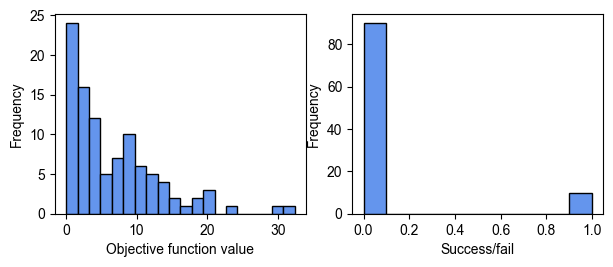

Mean RMSE Training: 1.681%
Mean RMSE High-DoD: 2.425%
Mean RMSE Low-DoD: 4.479%
Mean MAE Training: 1.403%
Mean MAE High-DoD: 1.981%
Mean MAE Low-DoD: 4.002%


In [33]:
X_train_PCA_3 = np.loadtxt("X_train_3_PCA.csv",delimiter=",")
X_test_in_PCA_3 = np.loadtxt("X_test_in_3_PCA.csv",delimiter=",")
X_test_out_PCA_3 = np.loadtxt("X_test_out_3_PCA.csv",delimiter=",")

X_train_PCA_3 = np.concatenate((np.ones((len(X_train_PCA_3),1)),X_train_PCA_3),axis=1)
X_test_in_PCA_3 = np.concatenate((np.ones((len(X_test_in_PCA_3),1)),X_test_in_PCA_3),axis=1)
X_test_out_PCA_3 = np.concatenate((np.ones((len(X_test_out_PCA_3),1)),X_test_out_PCA_3),axis=1)

results_3,best_result_3 = train_e2e(X_train_PCA_3,sample_scaled,method)

W_best_opt = best_result_3.x.reshape(num_features,3)
b_train_hat_e2e_3 = X_train_PCA_3@W_best_opt
b_test_in_hat_e2e_3 = X_test_in_PCA_3@W_best_opt
b_test_out_hat_e2e_3 = X_test_out_PCA_3@W_best_opt

# Evaluate training performance
Q_train_hat_e2e_3 = Q_train.copy()
RMSE_train_e2e_3 = []
MAE_train_ele_3 = []
for iii in range(len(Q_train)):
    Q_true = Q_train[iii]
    N_true = N_train[iii]
    Q_pred = empirical_model(a,*b_train_hat_e2e_3[iii],N_true)
    Q_train_hat_e2e_3[iii] = Q_pred

    RMSE_train_e2e_3.append(root_mean_squared_error(Q_true,Q_pred))
    MAE_train_ele_3.append(mean_absolute_error(Q_true,Q_pred))

# Evaluate test performance
Q_test_in_hat_e2e_3 = Q_test_in.copy()
RMSE_test_in_e2e_3 = []
MAE_test_in_e2e_3 = []
for iii in range(len(Q_test_in)):
    Q_true = Q_test_in[iii]
    N_true = N_test_in[iii]
    b_pred = np.abs(b_test_in_hat_e2e_3[iii])
    Q_pred = empirical_model(a,*b_pred,N_true)
    Q_test_in_hat_e2e_3[iii] = Q_pred

    RMSE_test_in_e2e_3.append(root_mean_squared_error(Q_true,Q_pred))
    MAE_test_in_e2e_3.append(mean_absolute_error(Q_true,Q_pred))

# Evaluate test performance
Q_test_out_hat_e2e_3 = Q_test_out.copy()
RMSE_test_out_e2e_3 = []
MAE_test_out_e2e_3 = []
for iii in range(len(Q_test_out)):
    Q_true = Q_test_out[iii]
    N_true = N_test_out[iii]
    b_pred = np.abs(b_test_out_hat_e2e_3[iii])
    Q_pred = empirical_model(a,*b_pred,N_true)
    Q_test_out_hat_e2e_3[iii] = Q_pred

    RMSE_test_out_e2e_3.append(root_mean_squared_error(Q_true,Q_pred))
    MAE_test_out_e2e_3.append(mean_absolute_error(Q_true,Q_pred))


print(f'Mean RMSE Training: {np.mean(RMSE_train_e2e_3)*100:.3f}%')
print(f'Mean RMSE High-DoD: {np.mean(RMSE_test_in_e2e_3)*100:.3f}%')
print(f'Mean RMSE Low-DoD: {np.mean(RMSE_test_out_e2e_3)*100:.3f}%')

print(f'Mean MAE Training: {np.mean(MAE_train_ele_3)*100:.3f}%')
print(f'Mean MAE High-DoD: {np.mean(MAE_test_in_e2e_3)*100:.3f}%')
print(f'Mean MAE Low-DoD: {np.mean(MAE_test_out_e2e_3)*100:.3f}%')

/var/folders/v6/55gp8_yx1993x56b4qjh3zqr0000gn/T/ipykernel_4268/4075118342.py:16: RuntimeWarning: overflow encountered in exp
  term_3 = I_nm /( I_nm + np.exp(  (X@w2@I_1m*1e2 -N) / (X@w3@I_1m*1e2 ) ))
/Users/litingkai/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


best MSE: 0.03263704771047066
best W: [ 6.36173628e+00  8.14058415e+00  1.81188597e+00  1.98156302e-01
  1.47156123e-01  6.43121494e-02 -3.16314595e-02 -1.94656115e-01
 -4.56622942e-02  8.32697103e-02  3.25153055e-01  1.63267631e-01
  3.57317845e-02  4.40372207e-01  4.86008791e-02  7.01450823e-02
 -1.38538364e+00 -3.15725324e-01  1.63559256e-01 -5.90229356e-01
 -1.87127573e-01  7.40544315e-01  1.64676285e-01 -1.05082179e-01
 -7.98268952e-01  1.03899760e+00  3.78140515e-01  4.93953202e-01
 -5.65397212e-02  6.45446522e-03  1.56612492e-01 -3.05996836e-01
 -2.89231264e-02]


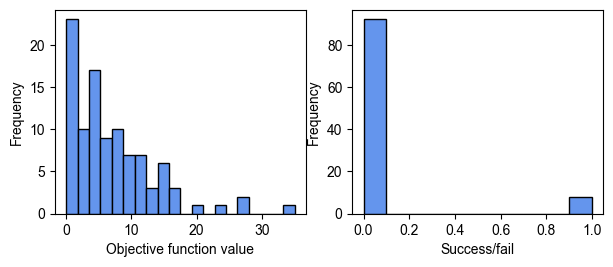

Mean RMSE Training: 1.707%
Mean RMSE High-DoD: 3.179%
Mean RMSE Low-DoD: 4.986%
Mean MAE Training: 1.431%
Mean MAE High-DoD: 2.783%
Mean MAE Low-DoD: 4.515%


In [34]:
X_train_PCA_5 = np.loadtxt("X_train_5_PCA.csv",delimiter=",")
X_test_in_PCA_5 = np.loadtxt("X_test_in_5_PCA.csv",delimiter=",")
X_test_out_PCA_5 = np.loadtxt("X_test_out_5_PCA.csv",delimiter=",")

X_train_PCA_5 = np.concatenate((np.ones((len(X_train_PCA_5),1)),X_train_PCA_5),axis=1)
X_test_in_PCA_5 = np.concatenate((np.ones((len(X_test_in_PCA_5),1)),X_test_in_PCA_5),axis=1)
X_test_out_PCA_5 = np.concatenate((np.ones((len(X_test_out_PCA_5),1)),X_test_out_PCA_5),axis=1)

results_5,best_result_5 = train_e2e(X_train_PCA_5,sample_scaled,method)

W_best_opt = best_result_5.x.reshape(num_features,3)
b_train_hat_e2e_5 = X_train_PCA_5@W_best_opt
b_test_in_hat_e2e_5 = X_test_in_PCA_5@W_best_opt
b_test_out_hat_e2e_5 = X_test_out_PCA_5@W_best_opt

# Evaluate training performance
Q_train_hat_e2e_5 = Q_train.copy()
RMSE_train_e2e_5 = []
MAE_train_ele_5 = []
for iii in range(len(Q_train)):
    Q_true = Q_train[iii]
    N_true = N_train[iii]
    Q_pred = empirical_model(a,*b_train_hat_e2e_5[iii],N_true)
    Q_train_hat_e2e_5[iii] = Q_pred

    RMSE_train_e2e_5.append(root_mean_squared_error(Q_true,Q_pred))
    MAE_train_ele_5.append(mean_absolute_error(Q_true,Q_pred))

# Evaluate test performance
Q_test_in_hat_e2e_5 = Q_test_in.copy()
RMSE_test_in_e2e_5 = []
MAE_test_in_e2e_5 = []
for iii in range(len(Q_test_in)):
    Q_true = Q_test_in[iii]
    N_true = N_test_in[iii]
    b_pred = np.abs(b_test_in_hat_e2e_5[iii])
    Q_pred = empirical_model(a,*b_pred,N_true)
    Q_test_in_hat_e2e_5[iii] = Q_pred

    RMSE_test_in_e2e_5.append(root_mean_squared_error(Q_true,Q_pred))
    MAE_test_in_e2e_5.append(mean_absolute_error(Q_true,Q_pred))

# Evaluate test performance
Q_test_out_hat_e2e_5 = Q_test_out.copy()
RMSE_test_out_e2e_5 = []
MAE_test_out_e2e_5 = []
for iii in range(len(Q_test_out)):
    Q_true = Q_test_out[iii]
    N_true = N_test_out[iii]
    b_pred = np.abs(b_test_out_hat_e2e_5[iii])
    Q_pred = empirical_model(a,*b_pred,N_true)
    Q_test_out_hat_e2e_5[iii] = Q_pred

    RMSE_test_out_e2e_5.append(root_mean_squared_error(Q_true,Q_pred))
    MAE_test_out_e2e_5.append(mean_absolute_error(Q_true,Q_pred))


print(f'Mean RMSE Training: {np.mean(RMSE_train_e2e_5)*100:.3f}%')
print(f'Mean RMSE High-DoD: {np.mean(RMSE_test_in_e2e_5)*100:.3f}%')
print(f'Mean RMSE Low-DoD: {np.mean(RMSE_test_out_e2e_5)*100:.3f}%')

print(f'Mean MAE Training: {np.mean(MAE_train_ele_5)*100:.3f}%')
print(f'Mean MAE High-DoD: {np.mean(MAE_test_in_e2e_5)*100:.3f}%')
print(f'Mean MAE Low-DoD: {np.mean(MAE_test_out_e2e_5)*100:.3f}%')

/var/folders/v6/55gp8_yx1993x56b4qjh3zqr0000gn/T/ipykernel_4268/4075118342.py:16: RuntimeWarning: overflow encountered in exp
  term_3 = I_nm /( I_nm + np.exp(  (X@w2@I_1m*1e2 -N) / (X@w3@I_1m*1e2 ) ))
/Users/litingkai/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


best MSE: 0.031777947047443696
best W: [ 5.98094717e+00  7.35284090e+00  1.65931013e+00  1.83450801e-01
  4.30647149e-02  3.33914780e-02  2.80945819e-02 -1.29036309e-01
 -3.93175824e-02 -3.24104959e-02  5.68904294e-01  1.86297813e-01
  5.14022307e-02 -3.13635524e-01  2.99523271e-02 -4.36861930e-01
 -2.08077341e-01 -5.79107285e-03  4.41676349e-01 -9.72369169e-01
 -3.16900995e-01  1.18050522e+00 -8.58888521e-01 -4.01280432e-01
  6.27312597e-01  2.01954125e-01 -4.92702770e-02 -2.50099401e-01
  6.95284456e-01  1.05362195e-01  2.48487486e-01  3.50673491e-01
  1.44469919e-01]


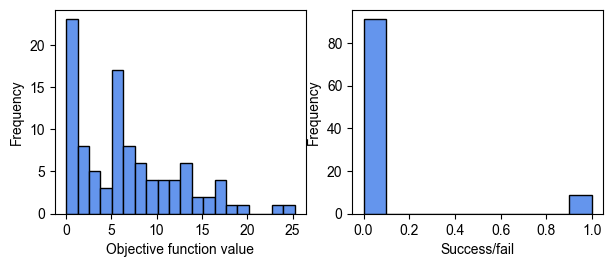

Mean RMSE Training: 1.680%
Mean RMSE High-DoD: 3.563%
Mean RMSE Low-DoD: 4.405%
Mean MAE Training: 1.410%
Mean MAE High-DoD: 3.199%
Mean MAE Low-DoD: 4.039%


In [35]:
X_train_PCA_6 = np.loadtxt("X_train_6_PCA.csv",delimiter=",")
X_test_in_PCA_6 = np.loadtxt("X_test_in_6_PCA.csv",delimiter=",")
X_test_out_PCA_6 = np.loadtxt("X_test_out_6_PCA.csv",delimiter=",")

X_train_PCA_6 = np.concatenate((np.ones((len(X_train_PCA_6),1)),X_train_PCA_6),axis=1)
X_test_in_PCA_6 = np.concatenate((np.ones((len(X_test_in_PCA_6),1)),X_test_in_PCA_6),axis=1)
X_test_out_PCA_6 = np.concatenate((np.ones((len(X_test_out_PCA_6),1)),X_test_out_PCA_6),axis=1)

results_6,best_result_6 = train_e2e(X_train_PCA_6,sample_scaled,method)

W_best_opt = best_result_6.x.reshape(num_features,3)
b_train_hat_e2e_6 = X_train_PCA_6@W_best_opt
b_test_in_hat_e2e_6 = X_test_in_PCA_6@W_best_opt
b_test_out_hat_e2e_6 = X_test_out_PCA_6@W_best_opt

# Evaluate training performance
Q_train_hat_e2e_6 = Q_train.copy()
RMSE_train_e2e_6 = []
MAE_train_ele_6 = []
for iii in range(len(Q_train)):
    Q_true = Q_train[iii]
    N_true = N_train[iii]
    Q_pred = empirical_model(a,*b_train_hat_e2e_6[iii],N_true)
    Q_train_hat_e2e_6[iii] = Q_pred

    RMSE_train_e2e_6.append(root_mean_squared_error(Q_true,Q_pred))
    MAE_train_ele_6.append(mean_absolute_error(Q_true,Q_pred))

# Evaluate test performance
Q_test_in_hat_e2e_6 = Q_test_in.copy()
RMSE_test_in_e2e_6 = []
MAE_test_in_e2e_6 = []
for iii in range(len(Q_test_in)):
    Q_true = Q_test_in[iii]
    N_true = N_test_in[iii]
    b_pred = np.abs(b_test_in_hat_e2e_6[iii])
    Q_pred = empirical_model(a,*b_pred,N_true)
    Q_test_in_hat_e2e_6[iii] = Q_pred

    RMSE_test_in_e2e_6.append(root_mean_squared_error(Q_true,Q_pred))
    MAE_test_in_e2e_6.append(mean_absolute_error(Q_true,Q_pred))

# Evaluate test performance
Q_test_out_hat_e2e_6 = Q_test_out.copy()
RMSE_test_out_e2e_6 = []
MAE_test_out_e2e_6 = []
for iii in range(len(Q_test_out)):
    Q_true = Q_test_out[iii]
    N_true = N_test_out[iii]
    b_pred = np.abs(b_test_out_hat_e2e_6[iii])
    Q_pred = empirical_model(a,*b_pred,N_true)
    Q_test_out_hat_e2e_6[iii] = Q_pred

    RMSE_test_out_e2e_6.append(root_mean_squared_error(Q_true,Q_pred))
    MAE_test_out_e2e_6.append(mean_absolute_error(Q_true,Q_pred))


print(f'Mean RMSE Training: {np.mean(RMSE_train_e2e_6)*100:.3f}%')
print(f'Mean RMSE High-DoD: {np.mean(RMSE_test_in_e2e_6)*100:.3f}%')
print(f'Mean RMSE Low-DoD: {np.mean(RMSE_test_out_e2e_6)*100:.3f}%')

print(f'Mean MAE Training: {np.mean(MAE_train_ele_6)*100:.3f}%')
print(f'Mean MAE High-DoD: {np.mean(MAE_test_in_e2e_6)*100:.3f}%')
print(f'Mean MAE Low-DoD: {np.mean(MAE_test_out_e2e_6)*100:.3f}%')

In [36]:
error_value = []
error_type = []
model_type = []
for iii in range(num_training_cells):
    error_value.append(RMSE_train_e2e_1[iii]*100)
    error_type.append('RMSE')
    model_type.append('$w1-w0$')

    error_value.append(MAE_train_ele_1[iii]*100)
    error_type.append('MAE')
    model_type.append('$w1-w0$')

    error_value.append(RMSE_train_e2e_2[iii]*100)
    error_type.append('RMSE')
    model_type.append('$w2-w0$')

    error_value.append(MAE_train_ele_2[iii]*100)
    error_type.append('MAE')
    model_type.append('$w2-w0$')

    error_value.append(RMSE_train_e2e_3[iii]*100)
    error_type.append('RMSE')
    model_type.append('$w3-w0$')

    error_value.append(MAE_train_ele_3[iii]*100)
    error_type.append('MAE')
    model_type.append('$w3-w0$')

    error_value.append(RMSE_train_e2e_5[iii]*100)
    error_type.append('RMSE')
    model_type.append('$w5-w0$')

    error_value.append(MAE_train_ele_5[iii]*100)
    error_type.append('MAE')
    model_type.append('$w5-w0$')

    error_value.append(RMSE_train_e2e_6[iii]*100)
    error_type.append('RMSE')
    model_type.append('$w6-w0$')

    error_value.append(MAE_train_ele_6[iii]*100)
    error_type.append('MAE')
    model_type.append('$w6-w0$')

train_df = pd.DataFrame({'model_type':model_type,
                         'error_type':error_type,
                         'error_value':error_value,
                         })

In [37]:
error_value = []
error_type = []
model_type = []

for iii in range(num_test_in_cells):
    error_value.append(RMSE_test_in_e2e_1[iii]*100)
    error_type.append('RMSE')
    model_type.append('$w1-w0$')

    error_value.append(MAE_test_in_e2e_1[iii]*100)
    error_type.append('MAE')
    model_type.append('$w1-w0$')

    error_value.append(RMSE_test_in_e2e_2[iii]*100)
    error_type.append('RMSE')
    model_type.append('$w2-w0$')

    error_value.append(MAE_test_in_e2e_2[iii]*100)
    error_type.append('MAE')
    model_type.append('$w2-w0$')

    error_value.append(RMSE_test_in_e2e_3[iii]*100)
    error_type.append('RMSE')
    model_type.append('$w3-w0$')

    error_value.append(MAE_test_in_e2e_3[iii]*100)
    error_type.append('MAE')
    model_type.append('$w3-w0$')

    error_value.append(RMSE_test_in_e2e_5[iii]*100)
    error_type.append('RMSE')
    model_type.append('$w5-w0$')

    error_value.append(MAE_test_in_e2e_5[iii]*100)
    error_type.append('MAE')
    model_type.append('$w5-w0$')

    error_value.append(RMSE_test_in_e2e_6[iii]*100)
    error_type.append('RMSE')
    model_type.append('$w6-w0$')

    error_value.append(MAE_test_in_e2e_6[iii]*100)
    error_type.append('MAE')
    model_type.append('$w6-w0$')

test_in_df = pd.DataFrame({'model_type':model_type,
                            'error_type':error_type,
                            'error_value':error_value,
                            })


In [38]:
error_value = []
error_type = []
model_type = []

for iii in range(num_test_out_cells):
    error_value.append(RMSE_test_out_e2e_1[iii]*100)
    error_type.append('RMSE')
    model_type.append('$w1-w0$')

    error_value.append(MAE_test_out_e2e_1[iii]*100)
    error_type.append('MAE')
    model_type.append('$w1-w0$')

    error_value.append(RMSE_test_out_e2e_2[iii]*100)
    error_type.append('RMSE')
    model_type.append('$w2-w0$')

    error_value.append(MAE_test_out_e2e_2[iii]*100)
    error_type.append('MAE')
    model_type.append('$w2-w0$')

    error_value.append(RMSE_test_out_e2e_3[iii]*100)
    error_type.append('RMSE')
    model_type.append('$w3-w0$')

    error_value.append(MAE_test_out_e2e_3[iii]*100)
    error_type.append('MAE')
    model_type.append('$w3-w0$')

    error_value.append(RMSE_test_out_e2e_5[iii]*100)
    error_type.append('RMSE')
    model_type.append('$w5-w0$')

    error_value.append(MAE_test_out_e2e_5[iii]*100)
    error_type.append('MAE')
    model_type.append('$w5-w0$')

    error_value.append(RMSE_test_out_e2e_6[iii]*100)
    error_type.append('RMSE')
    model_type.append('$w6-w0$')

    error_value.append(MAE_test_out_e2e_6[iii]*100)
    error_type.append('MAE')
    model_type.append('$w6-w0$')

test_out_df = pd.DataFrame({'model_type':model_type,
                            'error_type':error_type,
                            'error_value':error_value,
                            })

    

In [40]:
mean_MAE_train = [np.mean(MAE_train_ele_1)*100,
                  np.mean(MAE_train_ele_2)*100,
                  np.mean(MAE_train_ele_3)*100,
                  np.mean(MAE_train_ele_5)*100,
                  np.mean(MAE_train_ele_6)*100]

mean_MAE_test_in = [np.mean(MAE_test_in_e2e_1)*100,
                    np.mean(MAE_test_in_e2e_2)*100,
                    np.mean(MAE_test_in_e2e_3)*100,
                    np.mean(MAE_test_in_e2e_5)*100,
                    np.mean(MAE_test_in_e2e_6)*100]

mean_MAE_test_out = [np.mean(MAE_test_out_e2e_1)*100,
                        np.mean(MAE_test_out_e2e_2)*100,
                        np.mean(MAE_test_out_e2e_3)*100,
                        np.mean(MAE_test_out_e2e_5)*100,
                        np.mean(MAE_test_out_e2e_6)*100]

mean_RMSE_train = [np.mean(RMSE_train_e2e_1)*100,
                    np.mean(RMSE_train_e2e_2)*100,
                    np.mean(RMSE_train_e2e_3)*100,
                    np.mean(RMSE_train_e2e_5)*100,
                    np.mean(RMSE_train_e2e_6)*100]

mean_RMSE_test_in = [np.mean(RMSE_test_in_e2e_1)*100,
                    np.mean(RMSE_test_in_e2e_2)*100,
                    np.mean(RMSE_test_in_e2e_3)*100,
                    np.mean(RMSE_test_in_e2e_5)*100,
                    np.mean(RMSE_test_in_e2e_6)*100]

mean_RMSE_test_out = [np.mean(RMSE_test_out_e2e_1)*100,
                        np.mean(RMSE_test_out_e2e_2)*100,
                        np.mean(RMSE_test_out_e2e_3)*100,
                        np.mean(RMSE_test_out_e2e_5)*100,
                        np.mean(RMSE_test_out_e2e_6)*100]



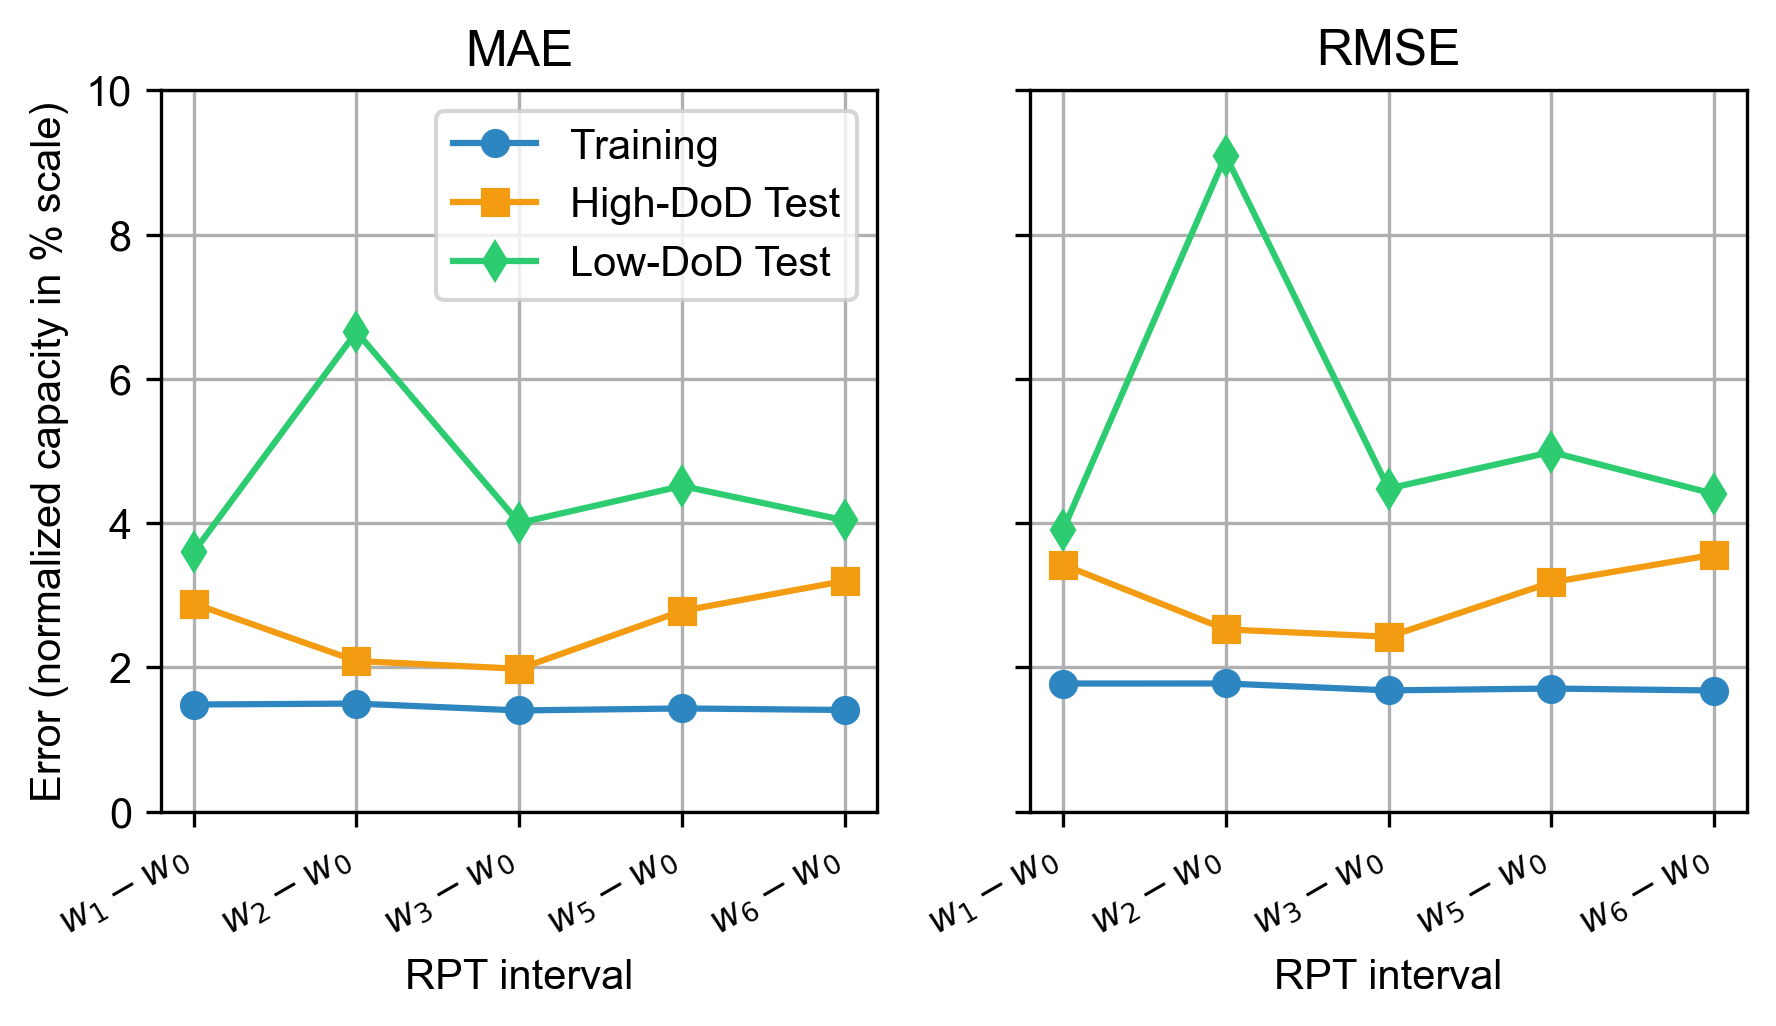

In [ ]:
colors = ["#2E86C1","#F39C12","#2ECC71",[0.5,0.5,0.5]]
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
fig,ax = plt.subplots(1,2,figsize=(6,3.5),dpi=300,sharey=True)
ax[0].plot(mean_MAE_train,'-o',c = colors[0],label='Training')
ax[0].plot(mean_MAE_test_in,'-s',c = colors[1],label='High-DoD Test')
ax[0].plot(mean_MAE_test_out,'-d',c = colors[2],label='Low-DoD Test')

ax[0].set_xticks([0,1,2,3,4])
ax[0].set_xticklabels(['$w_1-w_0$','$w_2-w_0$','$w_3-w_0$','$w_5-w_0$','$w_6-w_0$'],fontsize=9)
ax[0].set_ylabel('Error (normalized capacity in % scale)')
ax[0].set_xlabel('RPT interval')
ax[0].set_ylim(0,10)
ax[0].set_title('MAE')
ax[0].legend()
ax[0].grid()

ax[1].plot(mean_RMSE_train,'-o',c = colors[0],label='Training')
ax[1].plot(mean_RMSE_test_in,'-s',c = colors[1],label='High-DoD Test')
ax[1].plot(mean_RMSE_test_out,'-d',c = colors[2],label='Low-DoD Test')

ax[1].set_xticks([0,1,2,3,4])
ax[1].set_xticklabels(['$w_1-w_0$','$w_2-w_0$','$w_3-w_0$','$w_5-w_0$','$w_6-w_0$'],fontsize=9)
# ax[1].set_ylabel('RMSE (normalize capacity in %)')
ax[1].set_xlabel('RPT interval')
ax[1].set_ylim(0,10)
ax[1].set_title('RMSE')
ax[1].grid()

for ax_ in ax:
    ax_.tick_params(axis='x', rotation=30)  # Rotate the labels
    plt.setp(ax_.get_xticklabels(), ha='right')  # Align the labels to the right

plt.tight_layout(pad=1)
# plt.legend()
plt.show()


In [54]:
results = {'results_1':results_1,
           'results_2':results_2,
           'results_3':results_3,
           'results_5':results_5,
           'results_6':results_6}

best_result = {'best_result_1':best_result_1,
               'best_result_2':best_result_2,
               'best_result_3':best_result_3,
               'best_result_5':best_result_5,
               'best_result_6':best_result_6}

import pickle
with open('results_weekly_study.pkl','wb') as f:
    pickle.dump(results,f)

with open('best_result_weekly_study.pkl','wb') as f:
    pickle.dump(best_result,f)


In [ ]:

np.savetxt('Predicted_parameters/b_hat_e2e_1.csv',np.vstack((b_train_hat_e2e_1*np.array([[1e-3,1e2,1e2]]*num_training_cells),
                                        b_test_in_hat_e2e_1*np.array([[1e-3,1e2,1e2]]*num_test_in_cells),
                                        b_test_out_hat_e2e_1*np.array([[1e-3,1e2,1e2]]*num_test_out_cells))) ,delimiter=',')
np.savetxt('Predicted_parameters/b_hat_e2e_2.csv',np.vstack((b_train_hat_e2e_2*np.array([[1e-3,1e2,1e2]]*num_training_cells),
                                        b_test_in_hat_e2e_2*np.array([[1e-3,1e2,1e2]]*num_test_in_cells),
                                        b_test_out_hat_e2e_2*np.array([[1e-3,1e2,1e2]]*num_test_out_cells))) ,delimiter=',')
np.savetxt('Predicted_parameters/b_hat_e2e_3.csv',np.vstack((b_train_hat_e2e_3*np.array([[1e-3,1e2,1e2]]*num_training_cells),
                                        b_test_in_hat_e2e_3*np.array([[1e-3,1e2,1e2]]*num_test_in_cells),
                                        b_test_out_hat_e2e_3*np.array([[1e-3,1e2,1e2]]*num_test_out_cells))
                                        ),delimiter=',')
np.savetxt('Predicted_parameters/b_hat_e2e_5.csv',np.vstack((b_train_hat_e2e_5*np.array([[1e-3,1e2,1e2]]*num_training_cells),
                                        b_test_in_hat_e2e_5*np.array([[1e-3,1e2,1e2]]*num_test_in_cells),
                                        b_test_out_hat_e2e_5*np.array([[1e-3,1e2,1e2]]*num_test_out_cells))
                                        ),delimiter=',')

np.savetxt('Predicted_parameters/b_hat_e2e_6.csv',np.vstack((b_train_hat_e2e_6*np.array([[1e-3,1e2,1e2]]*num_training_cells),
                                        b_test_in_hat_e2e_6*np.array([[1e-3,1e2,1e2]]*num_test_in_cells),
                                        b_test_out_hat_e2e_6*np.array([[1e-3,1e2,1e2]]*num_test_out_cells))
                                        ),delimiter=',')

